## Image classification with Artificial Neural Networks using Keras

In [1]:
# Check if gpu is used (optional)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7576340578793076834
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18208043409346901332
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5297395118058415667
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2.3.1


In [9]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

## Loading the data

In the code below, the MNIST data is loaded and the features are rescaled. In this case we don't need a trainable scaler since the features are pixel values, i.e., integers between 0 and 155. We rescale them to be in [0,1] since this seems to work better with many neural network architectures.

There already is a predefined test set, but we split off a validation set (from the training data) of 10000 samples.

In [10]:
# load train and test data
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()


In [11]:
# let's print the shape before we reshape and normalize
print("X_train_all shape", X_train_all.shape)
print("y_train_all shape", y_train_all.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels = linearize the image to get a 784 (= 28x28) vector
X_train_all = X_train_all.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
# normalized data leads to better models
X_train_all = X_train_all.astype('float32')
X_test = X_test.astype('float32')
X_train_all /= 255
X_test /= 255

# print the final input shape 
print("Train_all matrix shape", X_train_all.shape)
print("Test matrix shape", X_test.shape)

X_train_all shape (60000, 28, 28)
y_train_all shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train_all matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [12]:
# This data set contains a training set and a test set
# we still need to split off a validation set

# Number of test samples
N_test = X_test.shape[0]

# split off 10000 samples for validation
N_val = 10000
N_train = X_train_all.shape[0] - N_val

# now extract the samples into train, validate and test sets
# set random state = 0 to make sure you get the same split each time
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size = N_val, random_state=0)


From the documentation of `train_test_split`:

>*test_size: float or int, default=None* 

>If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size (which is also a parameter). If train_size is also None, it will be set to 0.25.

## Multi-class classification

For multi-class classification problems with k classes, we train one model output per class. Each of the k outputs represents the probability that the sample comes from that class. This means the target labels are vectors of k values, all of which are zero except for that which corresponds to the correct class.

There are multiple ways to achieve this. Here, we will convert class vectors to binary class matrices instead of 1 integer label, you now have 10 binary labels (1 for each class) these labels represent the desired class probabilities: all labels are zero, except the one for the right class, which is one.

This will result in a model that outputs vectors of 10 probabilities when calling its 'predict()' function. In the analysis notebook, we will obtain class labels by finding the largest probability.

In [13]:
y_train_all = keras.utils.to_categorical(y_train_all)
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

# look at the new labels for the first sample
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


For classification, the output layer ends in a sigmoid activation. However, for multiple classes, it needs to be ensured that the outputs sum up to 1 (since they represent class probabilities). This is achieved with the 'softmax' activation function.

Since we are addressing a multi-class classification problem, with vectors of zeros and ones as labels, the loss function is 'categorical cross entropy'. 


In [17]:
num_classes = 10

# this first network has 2 hidden layers
# the first layer needs to be told explicitly what the input shape is
# the output layer has 10 neurons: one neuron per class (digit)

# Note that we use the "He" initialisation scheme here, since this is often advised 
# for layers with ReLu neurons

# Also note that "dropout" is implemented in separate layers in Keras
# they are added below in comment 
# note that you can also start your network with a dropout layer (randomly setting input features to 0)

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()


    # The first Dense object is the first hidden layer. Dense is one particular type of layer, but there are many other types
    # Dense is the most basic kind of layer in an ANN and each output of a dense layer is computed using every input to the layer
    # The input shape parameter input_shape=(784,) tells us how many neurons our input layer has, so in our case, we have 784.
    # The neural network needs to start with some weights and then iteratively updates them to better values. 
    # The term kernel_initializer is a fancy term for the statistical distribution or function 
    # to use for initialising the weights. 
    # The input layer shape is specified as a parameter to the first Dense object’s constructor.
    model.add(Dense(64, activation='relu', input_shape=(784,), kernel_initializer='he_uniform'))
    # then add some dropout, set at a very low value for now
    # model.add(Dropout(0.5))
    # a second dense layer with half as many neurons
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))    
    # some more dropout
    # model.add(Dropout(0.5))      
    # and the output layer
    model.add(Dense(num_classes, activation='softmax'))


    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see. 
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD. 
    model.compile(loss='categorical_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
                  metrics=['accuracy']) 
    return model



## Training 

The code below will introduce minibatches by specifying a batch size


In [18]:
# Create your model
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 128
epochs = 20

# We fit our model to the data. Fitting the model to the data means to train the model on the data.
# X_train is a numpy array consisting of the training samples.
# y_train is a numpy array consisting of the corresponding labels for the training samples.
# batch_size specifies how many training samples should be sent to the model at once.
# epochs = how many times the complete training set (all of the samples) will be passed to the model.
# verbose = 1 indicates how much logging we will see as the model trains. (other values are a.o. 0, 2)
history_1 = model_1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val)
                    )

# The output gives us the following values for each epoch:
# Epoch number
# Duration in seconds
# Loss
# Accuracy


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 1s 2ms/step - loss: 0.4462 - accuracy: 0.8772 - val_loss: 0.2248 - val_accuracy: 0.9333
Epoch 2/20
391/391 [==============================] - 1s 2ms/step - loss: 0.1993 - accuracy: 0.9429 - val_loss: 0.1816 - val_accuracy: 0.9463
Epoch 3/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1477 - accuracy: 0.9

Training set Accuracy:   1.00
Training set Loss: 0.0133

Validation set Accuracy:   0.97
Validation set Loss: 0.0990



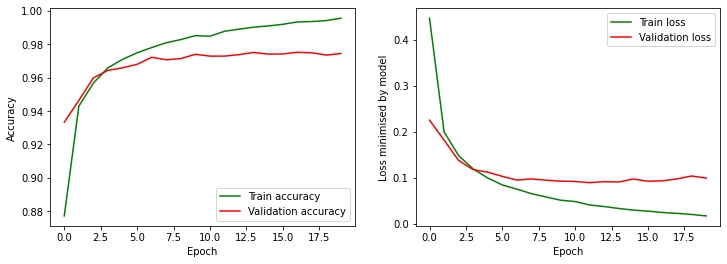

In [19]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(X_train, y_train, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(X_val, y_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

## Final model and analysis

Once you are happy with how your model performs on the validation set, it is time to re-train it on the original training set (i.e., including the validation set). This means that you no longer have a validation set to use during training. So you only have to execute the following steps once you are satisfied with the model you created!

Once this re-training has been done, you can analyse how your network performs on the test set.



In [21]:
model_for_test = initial_model()
model_for_test.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 128
epochs = 50

history_for_test = model_for_test.fit(X_train_all, y_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4159 - accuracy: 0.8813
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1680 - accuracy: 0.9509
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1236 - accuracy: 0.9634
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0971

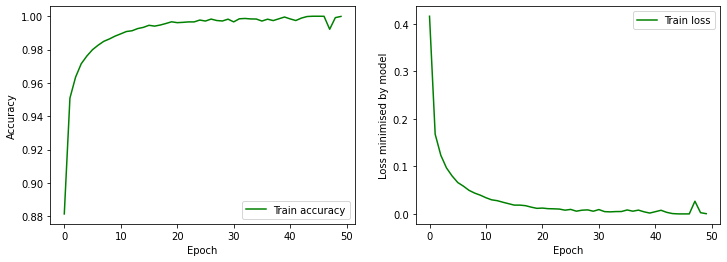

In [22]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

Finally we calculate the predictive accuracy of the model. 

In [23]:
[train_loss, train_accuracy] = model_for_test.evaluate(X_train_all, y_train_all, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(X_test, y_test, verbose=0)
print("Test set Accuracy:{:7.2f}".format(test_accuracy))
print("Test set Loss:{:7.4f}\n".format(test_loss))



Training set Accuracy:   1.00
Training set Loss: 0.0007

Test set Accuracy:   0.98
Test set Loss: 0.1366



## Evaluation

Finally, we visualize some incorrectly predicted digits.

In [24]:
predictions = model_for_test.predict(X_test)
# The first digit should be a 7 (shown as 1. at index 7)
print(y_test[0])

# Check the probabilities returned by predict for first test sample
# The function enumerate() receives and iterable and creates an iterator that, for each element, 
# returns a tuple containing the element's index and value
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')
    
# Our model believes this digit is a 7 with nearly 100% certainty
# Not all predictions have this level of certainty

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0: 0.0000000000%
1: 0.0000000000%
2: 0.0000000000%
3: 0.0000000000%
4: 0.0000000000%
5: 0.0000000000%
6: 0.0000000000%
7: 100.0000000000%
8: 0.0000000000%
9: 0.0000000000%


In the following snippet, p is the predicted value array, and e is the expected value array
NumPy’s argmax() function determines then index of an array’s highest valued element
Python's built-in zip function enables you to iterate over multiple iterables of data at the same time. The function receives as arguments any number of iterables and returns an iterator that produces tuples containing the elements at the same index in each.

In [25]:
# Locating the Incorrect Predictions
images = X_test.reshape((10000, 28, 28))

incorrect_predicted_images = []
predicted_digits = []
expected_digits = []

for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:  # prediction was incorrect
        incorrect_predicted_images.append(images[i])
        predicted_digits.append(predicted)
        expected_digits.append(expected)

<Figure size 432x288 with 0 Axes>

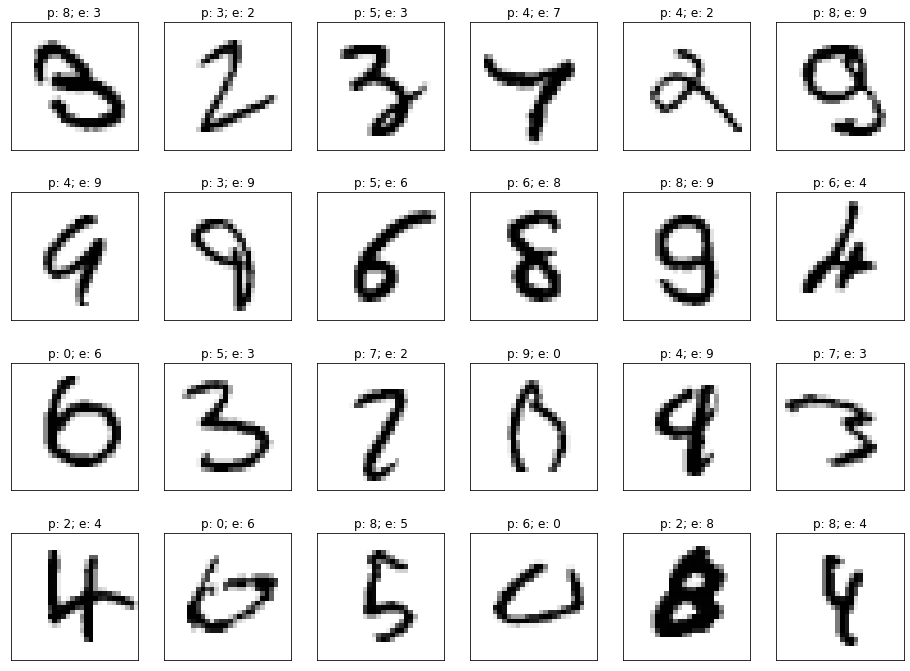

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure()
nrows,ncols=4,6
plt.subplots(nrows,ncols, figsize=(16, 12))

for i in range(nrows*ncols):  # show first 24 digits
  plt.subplot(nrows,ncols,i+1)  # i+1 is position of subplot in nrows x ncols table
  # show bitmap, interpret 0 as white and 255 as black (grayvalues)
  plt.imshow(incorrect_predicted_images[i].reshape(28,28), cmap=plt.cm.gray_r)
  plt.title(f'p: {predicted_digits[i]}; e: {expected_digits[i]}')
  plt.xticks([])   # no ticks on x axis
  plt.yticks([])   # not ticks on y axis